In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('traffic.csv')

In [3]:
df.isna().sum()

Time                    0
Traffic_Flow          300
Average_Speed         300
Occupancy             300
Temperature           300
Humidity              300
Wind_Speed            300
Precipitation         300
Visibility            300
Road_Condition        150
Traffic_Congestion      0
dtype: int64

In [4]:
threshold = int(df.shape[1] * 0.7)
df = df.dropna(thresh=df.shape[1] - threshold)

In [5]:
df['Road_Condition'].fillna('Unknown', inplace=True)

C:\Users\Jedi\AppData\Local\Temp\ipykernel_28808\2653824219.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Road_Condition'].fillna('Unknown', inplace=True)


In [6]:
df.isna().sum()

Time                  0
Traffic_Flow          0
Average_Speed         0
Occupancy             0
Temperature           0
Humidity              0
Wind_Speed            0
Precipitation         0
Visibility            0
Road_Condition        0
Traffic_Congestion    0
dtype: int64

In [7]:
df['Hour'] = pd.to_datetime(df['Time']).dt.hour
df['Day_Night'] = df['Hour'].apply(lambda x: 'Day' if 6 <= x < 18 else 'Night')
df = df.drop(columns=['Time', 'Hour'])

In [8]:
df

,Traffic_Flow,Average_Speed,Occupancy,Temperature,Humidity,Wind_Speed,Precipitation,Visibility,Road_Condition,Traffic_Congestion,Day_Night
0,102.0,95.208871,71.489953,24.730232,6.641042,1.613307,4.843614,5.615359,Snowy,Low,Night
1,435.0,22.227414,57.897765,8.805837,17.086020,27.731161,6.546673,0.003330,Snowy,Medium,Night
2,860.0,110.130299,1.460900,23.678285,31.112068,19.851620,19.707152,1.142456,Wet,High,Night
3,270.0,50.943291,36.037549,33.260058,32.069929,26.598680,7.363360,3.751952,Dry,Low,Night
5,71.0,97.889837,38.745130,0.729223,62.313292,3.938606,16.965885,1.335290,Dry,Low,Night
...,...,...,...,...,...,...,...,...,...,...,...
2994,38.0,70.758419,3.662970,5.110396,86.480381,0.524866,1.929640,5.735761,Wet,Low,Night
2995,908.0,8.085225,19.574603,-9.857157,39.042333,29.211387,1.396254,9.959174,Dry,High,Night
2996,158.0,99.784894,82.674243,33.180766,38.136846,14.165901,3.205072,9.941294,Wet,Low,Night
2997,582.0,21.279186,83.076739,16.645546,26.269763,11.807877,8.543912,4.240304,Wet,Medium,Night


In [9]:
cat_cols = df[['Traffic_Congestion', 'Road_Condition', 'Day_Night']]


In [10]:
X_encoded = pd.get_dummies(df, columns=cat_cols.columns.tolist(), drop_first=False)


X_encoded.to_csv('traffic_prep.csv', index=False)

In [11]:
df = pd.read_csv("traffic_prep.csv")
X = df.drop(columns=["Traffic_Flow"]).values
y = df["Traffic_Flow"].values.reshape(-1, 1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)



# Convert to PyTorch tensors


In [12]:
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)


In [13]:

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)



# Create TensorDatasets and DataLoaders


In [14]:

train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)



# Define Autoencoder for feature compression


In [15]:

class Autoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim=8):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, bottleneck_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded



# Train Autoencoder


In [16]:
autoencoder = Autoencoder(input_dim=X.shape[1])
ae_optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
ae_criterion = nn.MSELoss()

for epoch in range(50):
    autoencoder.train()
    for xb, _ in train_loader:
        ae_optimizer.zero_grad()
        output = autoencoder(xb)
        loss = ae_criterion(output, xb)
        loss.backward()
        ae_optimizer.step()



# Freeze encoder


In [17]:
encoded_train = autoencoder.encoder(X_train).detach()
encoded_test = autoencoder.encoder(X_test).detach()



# Define model without BatchNorm


In [18]:
class RegressorNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)



# Define model with BatchNorm


In [19]:
class RegressorBN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)


In [20]:

def train_model(model, X_train, y_train, X_test, y_test, epochs=100):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    train_losses, test_losses = [], []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            y_pred = model(X_train)
            train_loss = nn.MSELoss()(y_pred, y_train)
            test_pred = model(X_test)
            test_loss = nn.MSELoss()(test_pred, y_test)
        return [train_loss.item()] * epochs, [test_loss.item()] * epochs

        train_losses.append(loss.item())
        test_losses.append(test_loss.item())

    return train_losses, test_losses



# Train both models


In [21]:
model_plain = RegressorNN(input_dim=8)
model_bn = RegressorBN(input_dim=8)

train_plain, test_plain = train_model(model_plain, encoded_train, y_train, encoded_test, y_test)
train_bn, test_bn = train_model(model_bn, encoded_train, y_train, encoded_test, y_test)



# Plot loss comparison


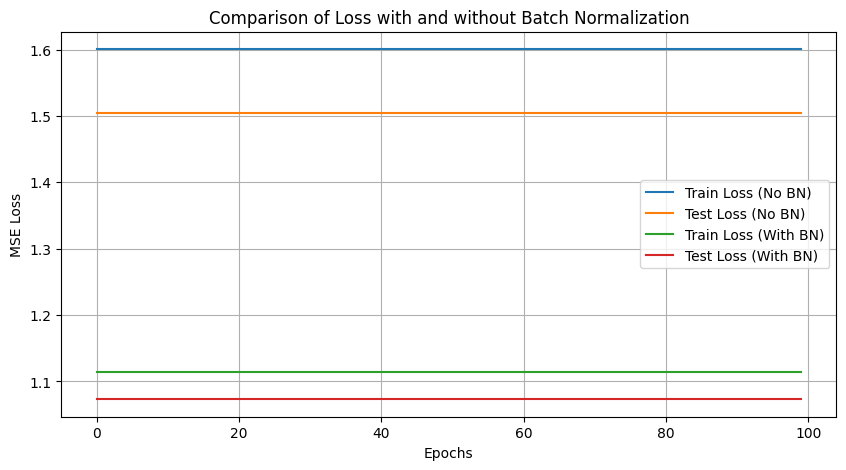

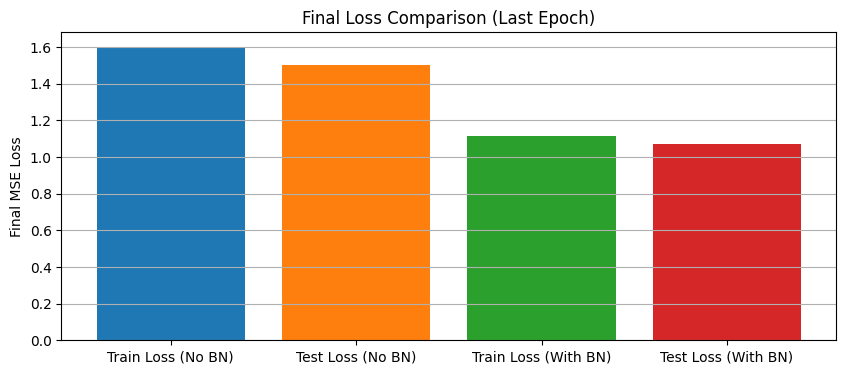

In [22]:
plt.figure(figsize=(10,5))
plt.plot(train_plain, label="Train Loss (No BN)")
plt.plot(test_plain, label="Test Loss (No BN)")
plt.plot(train_bn, label="Train Loss (With BN)")
plt.plot(test_bn, label="Test Loss (With BN)")
plt.legend()
plt.title("Comparison of Loss with and without Batch Normalization")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.grid(True)

bar_labels = ["Train Loss (No BN)", "Test Loss (No BN)", "Train Loss (With BN)", "Test Loss (With BN)"]
bar_values = [train_plain[-1], test_plain[-1], train_bn[-1], test_bn[-1]]
plt.figure(figsize=(10,4))
plt.bar(bar_labels, bar_values, color=['C0', 'C1', 'C2', 'C3'])
plt.ylabel("Final MSE Loss")
plt.title("Final Loss Comparison (Last Epoch)")
plt.grid(axis='y')
plt.show()
plt.show()

In [23]:
train_ds_encoded = TensorDataset(encoded_train, y_train)

full_batch_loader = DataLoader(train_ds_encoded, batch_size=len(encoded_train), shuffle=True)
mini_batch_loader = DataLoader(train_ds_encoded, batch_size=64, shuffle=True)
stochastic_loader = DataLoader(train_ds_encoded, batch_size=1, shuffle=True)

In [24]:
def train_with_loader(model, train_loader, X_test, y_test, epochs=50):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    train_losses, test_losses = [], []
    for epoch in range(epochs):
        model.train()
        batch_losses = []
        for xb, yb in train_loader:
            optimizer.zero_grad()
            y_pred = model(xb)
            loss = criterion(y_pred, yb)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        train_losses.append(np.mean(batch_losses))
        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            test_pred = model(X_test)
            test_loss = criterion(test_pred, y_test).item()
        test_losses.append(test_loss)
    return train_losses, test_losses

In [25]:
input_dim = encoded_train.shape[1]

model_full = RegressorNN(input_dim)
train_full, test_full = train_with_loader(model_full, full_batch_loader, encoded_test, y_test)

model_mini = RegressorNN(input_dim)
train_mini, test_mini = train_with_loader(model_mini, mini_batch_loader, encoded_test, y_test)

model_stoch = RegressorNN(input_dim)
train_stoch, test_stoch = train_with_loader(model_stoch, stochastic_loader, encoded_test, y_test)

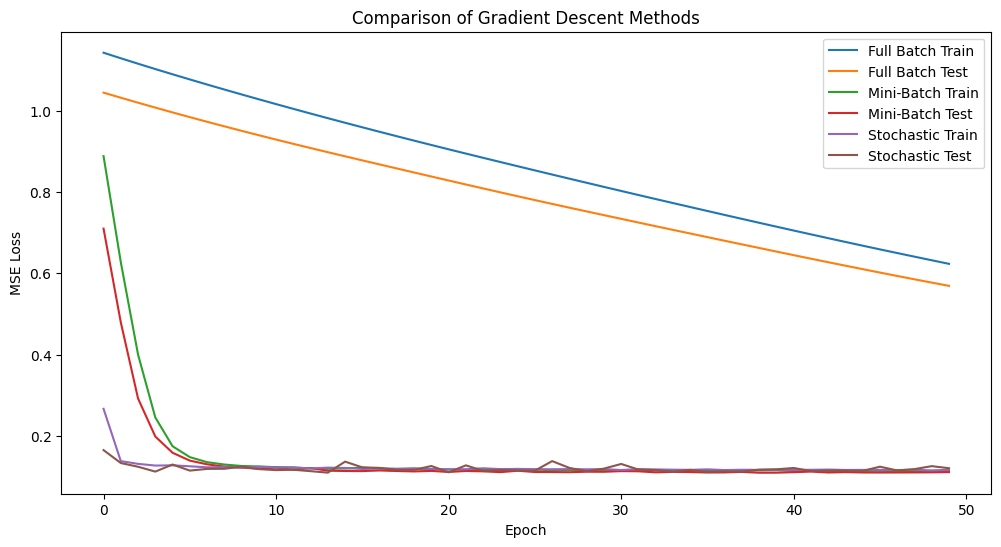

In [26]:
plt.figure(figsize=(12,6))
plt.plot(train_full, label='Full Batch Train')
plt.plot(test_full, label='Full Batch Test')
plt.plot(train_mini, label='Mini-Batch Train')
plt.plot(test_mini, label='Mini-Batch Test')
plt.plot(train_stoch, label='Stochastic Train')
plt.plot(test_stoch, label='Stochastic Test')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Comparison of Gradient Descent Methods')
plt.legend()
plt.show()